In [22]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob
from sunpy import timeseries as ts 
import datetime
from scipy.signal import savgol_filter
from astropy import units as u
from matplotlib import dates
import seaborn as sns
import scipy.stats


import warnings
warnings.filterwarnings("ignore")

In [23]:
flare_list = pd.read_csv("flare_list_w_fwhm.csv")

flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])
flare_list["event_endtime"] = pd.to_datetime(flare_list["event_endtime"])
flare_list["event_peaktime"] = pd.to_datetime(flare_list["event_peaktime"])

In [24]:
data_dir = '/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/'

In [4]:
flare_list = flare_list[flare_list["goes_class_ind"].isin(["X", "M"])]
flare_list.reset_index(inplace=True, drop=True)


## Lets try the Reep et al. 2021 method

In [60]:
def plot_testy(i):
    tstart = flare_list.iloc[i]["event_starttime"]
    tend = flare_list.iloc[i]["event_endtime"]
    tpeak = flare_list.iloc[i]["event_peaktime"]

    file_s = pd.to_datetime(tstart).strftime("*%Y%m%d.fits")
    file_e = pd.to_datetime(tend).strftime("*%Y%m%d.fits")


    if file_s == file_e:
        goes = ts.TimeSeries(data_dir + file_s)
    else:
        goes = ts.TimeSeries(data_dir + file_s, data_dir + file_e, concatenate=True)

    goes_flare = goes.truncate(tstart - datetime.timedelta(minutes=10), tend + datetime.timedelta(minutes=60))

    goes_flare = goes_flare.add_column('xrsa_deriv',
                           savgol_filter(goes_flare.to_dataframe()['xrsa'], 7, 4, deriv=1) * goes_flare.units['xrsa'] / u.s)
    goes_flare = goes_flare.add_column('xrsb_deriv',
                           savgol_filter(goes_flare.to_dataframe()['xrsb'], 7, 4, deriv=1) * goes_flare.units['xrsb'] / u.s)

    goes_data = goes_flare.to_table()

    try:
        t0 = np.where(goes_data['xrsb_deriv'] > np.max(goes_data['xrsb'])/1e4)[0][0]
    except:
        t0 = 0

    try:
        t1 = np.where(goes_data['xrsb_deriv'] == np.max(goes_data['xrsb_deriv']))[0][0]
    except:
        t1=0

    try:
        t2 = np.where(goes_data['xrsb'] == np.max(goes_data['xrsb']))[0][0]
    except:
        t2 = 0
    try:
        t3 = np.where(goes_data['xrsb_deriv'] == np.min(goes_data['xrsb_deriv']))[0][0]
    except: 
        t3=0
    try:
        temp_deriv = np.copy(goes_data['xrsb_deriv'])
        temp_deriv[np.logical_or(goes_data['xrsb_deriv'] >= 0.0,
                                 np.indices(goes_data['xrsb_deriv'].shape) <= t3)[0]] = -1e100
        t4 = np.where(temp_deriv > (-1.0) * np.max(goes_data['xrsb'])/1e4)[0][0]
    except:
        t4=0

    gl = goes_flare.to_dataframe()["xrsb"]
    gs = goes_flare.to_dataframe()["xrsa"]

    gl_deriv = goes_flare.to_dataframe()["xrsb_deriv"]

    peak_half = gl[0] + (np.max(gl) - gl[0])/2 

    fwhm = gl[gl > peak_half]

    fig, ax = plt.subplots()
    ax.plot(gl)

#     ax2 = ax.twinx()
#     ax2.plot(gl_deriv, color="grey", lw=0.5)
    ax.axvline(gl.index[t0], color="r")
    ax.axvline(gl.index[t1])
    ax.axvline(gl.index[t3])
    ax.axvline(gl.index[t4], color="r")


    ax.axvline(tstart, color="k", ls="dashed")
    ax.axvline(tpeak, color="k", ls="dashed")
    ax.axvline(tend, color="k", ls="dashed")

    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    ax.set_xlabel(tstart)

    plt.savefig("./testy_plots/plot_flare_{:s}.png".format(tstart.strftime("%Y%m%d%H%M")), facecolor="w")
    plt.close()
    
    
    return gl.index[t0], gl.index[t1], gl.index[t2], gl.index[t3], gl.index[t4]

In [62]:
def do_jeff_test():
    errors = []
    t0_list, t1_list, t2_list, t3_list, t4_list = [], [], [], [], []

    for i in range(len(flare_list)):
        print(i)
        try:
            t0, t1, t2, t3, t4 = plot_testy(i)
            t0_list.append(t0); t1_list.append(t1); t2_list.append(t2); t3_list.append(t3); t4_list.append(t4)
        except:
            print("error!", i)
            t0_list.append(np.nan); t1_list.append(np.nan); t2_list.append(np.nan); t3_list.append(np.nan); t4_list.append(np.nan)        
            
            
    flare_list["t0"] = t0_list
    flare_list["t1"] = t1_list
    flare_list["t2"] = t2_list
    flare_list["t3"] = t3_list
    flare_list["t4"] = t4_list

    testy = flare_list[(flare_list["t4"] > flare_list["t3"]) & (flare_list["t3"] > flare_list["t2"]) & \
                (flare_list["t2"] > flare_list["t1"]) & (flare_list["t1"] > flare_list["t0"])]
    
    testy["dur_jeff"] = [x.total_seconds() for x in (testy["t4"] - testy["t0"])]
    testy["decay_jeff"] = [x.total_seconds() for x in (testy["t4"] - testy["t2"])]
    testy["rise_jeff"] = [x.total_seconds() for x in (testy["t2"] - testy["t0"])]

    testy.to_csv("testy_jeff.csv", index_label=False)

## Lets try the Tourimi et al. 2017 method

In [191]:
flare_list = flare_list[flare_list["goes_class_ind"].isin(["X"])]
flare_list.reset_index(inplace=True, drop=True)

In [226]:
i=0
def get_times(i):
    tstart = flare_list.iloc[i]["event_starttime"]
    tend = flare_list.iloc[i]["event_endtime"]
    tpeak = flare_list.iloc[i]["event_peaktime"]

    file_s = pd.to_datetime(tstart).strftime("*%Y%m%d.fits")
    file_e = pd.to_datetime(tend).strftime("*%Y%m%d.fits")


    if file_s == file_e:
        goes = ts.TimeSeries(data_dir + file_s)
    else:
        goes = ts.TimeSeries(data_dir + file_s, data_dir + file_e, concatenate=True)


    tstart_new = tstart
    tend_new = tend+datetime.timedelta(minutes=20)
    goes_flare = goes.truncate(tstart_new, tend_new)
    gl = goes_flare.to_dataframe()["xrsb"]
    gs = goes_flare.to_dataframe()["xrsa"]

    gl_bg = gl - gl[0]
    gs_bg = gs - gs[0]

    half_peak = np.max(gl_bg)/2

    fwhm = gl_bg[gl_bg >= half_peak]
    fwhm_s = min(fwhm.index)
    fwhm_e = max(fwhm.index)

    fwhm_seconds = (fwhm_e - fwhm_s).total_seconds()
    fwhm_rise = (fwhm.index[np.argmax(fwhm)] - fwhm_s).total_seconds()
    fwhm_decay = (fwhm_e - fwhm.index[np.argmax(fwhm)]).total_seconds()
    #print(fwhm_seconds)



    e_fold_value = np.max(gl_bg)*1/np.exp(1)

    gl_bg_test = gl_bg.truncate(tpeak, tend_new)

    tend_efold = gl_bg_test.index[np.argmin(np.abs(gl_bg_test - e_fold_value))]

    t_decay = (tend_efold - tpeak).total_seconds()
    #print(t_decay)
    #return fwhm_rise, fwhm_decay, fwhm_seconds, t_decay

    gl_bg.plot()
    gs_bg.plot()
    plt.axvline(tstart)
    plt.axvline(tend)
    plt.axvline(tpeak)

    plt.axhline(half_peak, color="r")
    plt.xlabel(tstart)



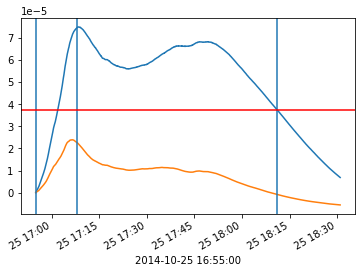

In [227]:
get_times(38)

In [215]:
fwhm_list = []
t_decay = []
fwhm_rise = []
fwhm_decay = []
for i in range(len(flare_list)):
    fwhm_r, fwhm_d, fwhm, td = get_times(i)
    fwhm_rise.append(fwhm_r)
    fwhm_decay.append(fwhm_d)
    fwhm_list.append(fwhm)
    t_decay.append(td)

In [217]:
flare_list["fwhm_new"] = fwhm_list
flare_list["t_decay"] = t_decay
flare_list["fwhm_rise"] = fwhm_rise
flare_list["fwhm_decay"] = fwhm_decay

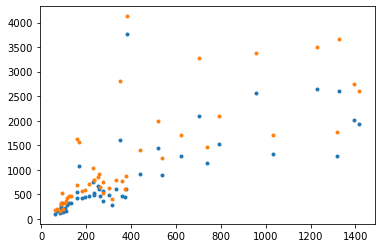

In [230]:
plt.plot(flare_list.fwhm_rise, flare_list.fwhm_decay, marker='.', ls='')
plt.plot(flare_list.fwhm_rise, flare_list.t_decay, marker='.', ls='')

In [221]:
flare_list[flare_list.fwhm_decay>3500]

,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,...,dur_full,t0,t1,t2,t3,t4,fwhm_new,t_decay,fwhm_rise,fwhm_decay
38,2014-10-25 16:55:00,2014-10-25 17:08:00,2014-10-25 18:11:00,X,X1.0,0.0001,0.39,12192,S10W22,-10.0,...,4560.0,2014-10-25 16:45:01.198999882,2014-10-25 17:03:57.824999809,2014-10-25 17:08:19.964999914,2014-10-25 17:15:44.375,2014-10-25 17:16:04.855000019,4145.107,4128.208999,380.923,3764.184


/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fwhm_new', ylabel='Density'>

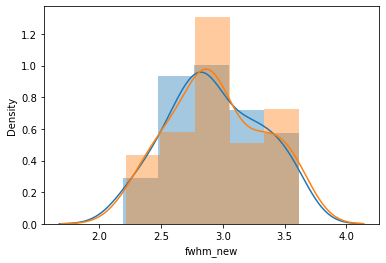

In [234]:
sns.distplot(np.log10(flare_list["t_decay"]))
sns.distplot(np.log10(flare_list["fwhm_new"]))

In [285]:
i

4942

In [25]:
flare_list[flare_list["event_starttime"]>="2012-07-19"]

,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,hgs_lon,hpc_x,hpc_y,tt,matchtime,fwhm,dur_full
2371,2012-07-19 00:00:00,2012-07-19 00:09:00,2012-07-19 00:14:00,C,C2.4,0.000002,0.00150,11524,S16E38,-16.0,-38.0,-560.479805,-319.340223,80239860.0,2012-07-19 00:30,563.199999,840.0
2372,2012-07-19 01:34:00,2012-07-19 01:37:00,2012-07-19 01:39:00,C,C1.3,0.000001,0.00023,11524,S16E37,-16.0,-37.0,-547.902378,-320.227884,80245500.0,2012-07-19 00:30,210.942999,300.0
2373,2012-07-19 04:17:00,2012-07-19 05:58:00,2012-07-19 06:56:00,M,M7.7,0.000077,0.36000,11520,S13W88,-13.0,88.0,919.203888,-214.271994,80255280.0,2012-07-19 00:30,5595.103999,9540.0
2374,2012-07-19 18:32:00,2012-07-19 18:36:00,2012-07-19 18:38:00,C,C1.5,0.000002,0.00032,11525,S22E25,-22.0,-25.0,-371.245743,-420.324390,80306580.0,2012-07-19 00:30,180.220000,360.0
2375,2012-07-19 21:44:00,2012-07-19 21:48:00,2012-07-19 21:51:00,C,C1.1,0.000001,0.00029,11525,S22E23,-22.0,-23.0,-343.258607,-421.561234,80318100.0,2012-07-19 00:30,212.993000,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,2018-05-23 18:03:00,2018-05-23 18:21:00,2018-05-23 18:33:00,C,C2.0,0.000002,0.00240,12712,NaN,NaN,NaN,NaN,NaN,264682440.0,2018-05-23 00:30,1140.726999,1800.0
8593,2018-05-28 17:04:00,2018-05-28 17:10:00,2018-05-28 17:12:00,C,C2.7,0.000003,0.00044,12712,NaN,NaN,NaN,NaN,NaN,265110900.0,2018-05-28 00:30,417.786000,480.0
8594,2018-06-06 10:44:00,2018-06-06 11:00:00,2018-06-06 11:06:00,C,C1.0,0.000001,0.00066,12712,NaN,NaN,NaN,NaN,NaN,265865700.0,2018-06-06 00:30,503.802999,1320.0
8595,2018-06-21 01:09:00,2018-06-21 01:15:00,2018-06-21 01:18:00,C,C2.1,0.000002,0.00064,12715,NaN,NaN,NaN,NaN,NaN,267127200.0,2018-06-21 00:30,319.490000,540.0


In [21]:
len(flare_list)

797

## Finding tests

In [29]:
i = np.random.randint(len(flare_list))
# i = 4942
i=2373


def get_fwhm(i, plot_debug=False):
    tstart = flare_list.iloc[i]["event_starttime"]
    tend = flare_list.iloc[i]["event_endtime"]
    tpeak = flare_list.iloc[i]["event_peaktime"]

    file_s = pd.to_datetime(tstart).strftime("*%Y%m%d.fits")
    file_e = pd.to_datetime(tend).strftime("*%Y%m%d.fits")


    if file_s == file_e:
        goes = ts.TimeSeries(data_dir + file_s)
    else:
        goes = ts.TimeSeries(data_dir + file_s, data_dir + file_e, concatenate=True)


    tstart_new = tstart
    tend_new = tend+datetime.timedelta(minutes=40)
    goes_flare = goes.truncate(tstart_new, tend_new)
    gl = goes_flare.to_dataframe()["xrsb"]
    gs = goes_flare.to_dataframe()["xrsa"]

    gl_bg = gl - gl[0]
    gs_bg = gs - gs[0]


    # get FWHM values
    half_peak =  gl_bg[np.argmin(np.abs(gl_bg.index - tpeak))]/2
    threshold = half_peak

    
    
    gl_end = gl_bg.truncate(tpeak, tend_new)
    indices_fwhm_end = (gl_end < threshold) & (gl_end.shift(1) >= threshold)

    gl_start = gl_bg.truncate(tstart, tpeak)
    indices_fwhm_start = (gl_start > threshold) & (gl_start.shift(1) <= threshold)


    if np.sum(indices_fwhm_end)>0:
        fwhm_end = gl_end[indices_fwhm_end].index[0]

    if np.sum(indices_fwhm_start)>0:
        fwhm_start = gl_start[indices_fwhm_start].index[0]

        
    e_fold_value = gl_bg[np.argmin(np.abs(gl_bg.index - tpeak))]*1/np.exp(1)
    indices_efold = (gl_end < e_fold_value) & (gl_end.shift(1) >= e_fold_value)
    
    if np.sum(indices_efold)>0:
        e_fold_t = gl_end[indices_efold].index[0]    
    
    if plot_debug:
        plt.plot(gl_bg)
        plt.axvline(tpeak)
        plt.axhline(threshold)
        plt.axvline(tend, ls="dashed")
        plt.axvline(tstart, ls="dashed")
        plt.axvline(fwhm_end, color="r")
        plt.axvline(fwhm_start, color="r")
        plt.axvline(e_fold_t, color="g")
    return fwhm_start, fwhm_end, e_fold_t


(Timestamp('2012-07-19 05:26:48.594999909'),
 Timestamp('2012-07-19 07:00:05.748999953'),
 Timestamp('2012-07-19 07:18:54.188999891'))

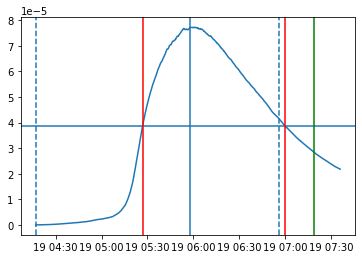

In [30]:
get_fwhm(2373, plot_debug=True)

In [424]:
flare_list = flare_list[flare_list["goes_class_ind"].isin(["X", "M"])]
flare_list.reset_index(inplace=True, drop=True)

# Plot example

In [31]:
i = 2373
tstart = flare_list.iloc[i]["event_starttime"]
tend = flare_list.iloc[i]["event_endtime"]
tpeak = flare_list.iloc[i]["event_peaktime"]

file_s = pd.to_datetime(tstart).strftime("*%Y%m%d.fits")
file_e = pd.to_datetime(tend).strftime("*%Y%m%d.fits")


if file_s == file_e:
    goes = ts.TimeSeries(data_dir + file_s)
else:
    goes = ts.TimeSeries(data_dir + file_s, data_dir + file_e, concatenate=True)


tstart_new = tstart
tend_new = tend+datetime.timedelta(minutes=40)
goes_flare = goes.truncate(tstart_new, tend_new)
gl = goes_flare.to_dataframe()["xrsb"]
gs = goes_flare.to_dataframe()["xrsa"]

gl_bg = gl - gl[0]
gs_bg = gs - gs[0]


# get FWHM values
half_peak =  gl_bg[np.argmin(np.abs(gl_bg.index - tpeak))]/2
threshold = half_peak



gl_end = gl_bg.truncate(tpeak, tend_new)
indices_fwhm_end = (gl_end < threshold) & (gl_end.shift(1) >= threshold)

gl_start = gl_bg.truncate(tstart, tpeak)
indices_fwhm_start = (gl_start > threshold) & (gl_start.shift(1) <= threshold)


if np.sum(indices_fwhm_end)>0:
    fwhm_end = gl_end[indices_fwhm_end].index[0]

if np.sum(indices_fwhm_start)>0:
    fwhm_start = gl_start[indices_fwhm_start].index[0]


e_fold_value = gl_bg[np.argmin(np.abs(gl_bg.index - tpeak))]*1/np.exp(1)
indices_efold = (gl_end < e_fold_value) & (gl_end.shift(1) >= e_fold_value)

if np.sum(indices_efold)>0:
    e_fold_t = gl_end[indices_efold].index[0]    

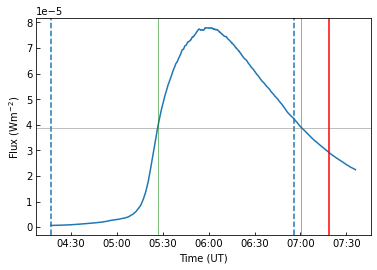

In [48]:
fig, ax = plt.subplots()
ax.plot(gl)
# ax.set_yscale("log")

ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

ax.axvline(tstart, ls="dashed")
ax.axvline(tend, ls="dashed")


ax.axhline(half_peak, color="grey", lw=0.5)

ax.axvline(e_fold_t, color="r")

ax.axvline(fwhm_start, color="green", lw=0.5)
ax.axvline(fwhm_end, color="green", lw=0.5)

plt.tick_params(which="both", direction="in")

ax.set_ylabel("Flux (Wm$^{-2}$)")
ax.set_xlabel("Time (UT)")
plt.savefig("example_durations.png", dpi=200, facecolor="w")

In [425]:
errors = []
fwhm_start = []
fwhm_end = []
e_fold_t = []

for i in range(len(flare_list)):
    try:
        f_s, f_e, efold = get_fwhm(i)
        fwhm_start.append(f_s)
        fwhm_end.append(f_e)
        e_fold_t.append(efold)
    except:
        print("error", i)
        errors.append(i)
        fwhm_start.append(np.nan)
        fwhm_end.append(np.nan)
        e_fold_t.append(np.nan)
    

error 49
error 84
error 88
error 95
error 117
error 145
error 150
error 190
error 191
error 217
error 235
error 237
error 238
error 244
error 265
error 266
error 267
error 268
error 269
error 292
error 320
error 328
error 349
error 393
error 473
error 475
error 498
error 519
error 524
error 526
error 529
error 535
error 542
error 578
error 597
error 606
error 613
error 632
error 639
error 644
error 651
error 656
error 665
error 678
error 683
error 707
error 713
error 737
error 763
error 764
error 767
error 773
error 777


In [426]:
flare_list["fwhm_start"] = fwhm_start
flare_list["fwhm_end"] = fwhm_end
flare_list["efold_decay"] = e_fold_t

In [427]:
e_fold_t[0]

Timestamp('2010-01-19 13:55:50.958999872')

In [428]:
flare_list["fwhm_rise"] = [x.total_seconds() for x in (flare_list["event_peaktime"]-flare_list["fwhm_start"])]
flare_list["fwhm_decay"] = [x.total_seconds() for x in (flare_list["fwhm_end"]-flare_list["event_peaktime"])]
flare_list["fwhm_dur"] = [x.total_seconds() for x in (flare_list["fwhm_end"]-flare_list["fwhm_start"])]
flare_list["efold_decay_dur"] = [x.total_seconds() for x in (flare_list["efold_decay"]-flare_list["event_peaktime"])]

<AxesSubplot:xlabel='fwhm_dur', ylabel='Density'>

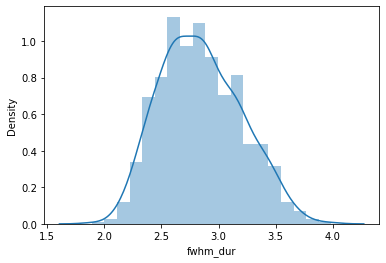

In [429]:
sns.distplot(np.log10(flare_list["fwhm_dur"]))

<AxesSubplot:xlabel='efold_decay_dur', ylabel='Density'>

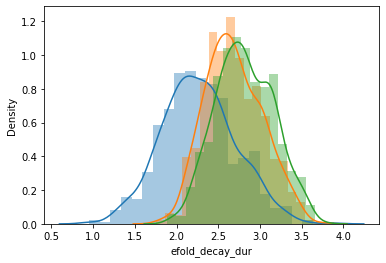

In [431]:
sns.distplot(np.log10(flare_list["fwhm_rise"]))
sns.distplot(np.log10(flare_list["fwhm_decay"]))
sns.distplot(np.log10(flare_list["efold_decay_dur"]))

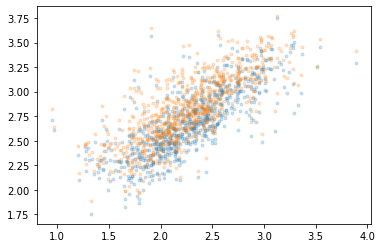

In [435]:
plt.scatter(np.log10(flare_list["fwhm_rise"]), np.log10(flare_list["fwhm_decay"]), alpha=0.2, marker='.')
plt.scatter(np.log10(flare_list["fwhm_rise"]), np.log10(flare_list["efold_decay_dur"]), alpha=0.2, marker='.')

In [416]:
flare_list.to_csv("test_fwhm.csv", index_label=False)

In [437]:
flare_list.iloc[errors]

,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,...,matchtime,fwhm,dur_full,fwhm_start,fwhm_end,fwhm_rise,fwhm_decay,fwhm_dur,efold_decay,efold_decay_dur
49,2011-03-08 19:46:00,2011-03-08 20:16:00,2011-03-08 21:19:00,M,M1.4,0.000014,0.06700,11165,NaN,NaN,...,2011-03-08 00:30,5472.184000,5580.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
84,2011-09-09 06:01:00,2011-09-09 06:11:00,2011-09-09 06:17:00,M,M2.7,0.000027,0.01500,11283,N14W48,14.0,...,2011-09-09 00:30,528.376000,960.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
88,2011-09-22 09:53:00,2011-09-22 10:00:00,2011-09-22 10:09:00,M,M1.1,0.000011,0.00760,11302,N24W55,24.0,...,2011-09-22 00:30,1452.006999,960.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
95,2011-09-24 16:36:00,2011-09-24 16:59:00,2011-09-24 17:15:00,M,M1.7,0.000017,0.03200,11295,N23W87,23.0,...,2011-09-24 00:30,587.765999,2340.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
117,2011-10-22 10:00:00,2011-10-22 11:10:00,2011-10-22 13:09:00,M,M1.3,0.000013,0.11000,11314,N27W87,27.0,...,2011-10-22 00:30,9482.087000,11340.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
145,2012-01-19 13:44:00,2012-01-19 16:05:00,2012-01-19 17:50:00,M,M3.2,0.000032,0.27000,11402,N32E27,32.0,...,2012-01-19 00:30,9424.800000,14760.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
150,2012-03-04 10:29:00,2012-03-04 10:52:00,2012-03-04 12:16:00,M,M2.0,0.000020,0.09200,11429,N16E65,16.0,...,2012-03-04 00:30,5635.996999,6420.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
190,2012-06-13 11:29:00,2012-06-13 13:17:00,2012-06-13 14:31:00,M,M1.2,0.000012,0.07500,11504,S18E21,-18.0,...,2012-06-13 00:30,7503.756999,10920.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
191,2012-06-14 12:52:00,2012-06-14 14:35:00,2012-06-14 15:56:00,M,M1.9,0.000019,0.12000,11504,S19E06,-19.0,...,2012-06-14 00:30,7184.276000,11040.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
217,2012-07-05 21:37:00,2012-07-05 21:45:00,2012-07-05 21:51:00,M,M1.6,0.000016,0.00860,11515,S12W45,-12.0,...,2012-07-05 00:30,917.500000,840.0,NaT,NaT,NaN,NaN,NaN,NaT,NaN
